# Dust to gas scaling relations with Jupyter Notebooks
## Introduction
This notebook demonstrate how the combination of Jupyter Notebooks, Python and the Virtual Observatory can create scientific results and leads to a discussuion, of what is still missing. 

The science case, which this notebook is going to tackle, concerns the dust content of very HI-rich galaxies. A sample of these galaxies, namely the HIX sample has been compiled and studied before (Lutz et al. 2017, 2018, in preparation). These galaxies have been selected to host at least 2.5 times more HI than expected from their optical luminosity based on scaling relations by Denes et al. (2014). When comparing the HIX galaxies with a dedicated control sample, it was found that HIX galaxies host large amounts of HI at large radii, where the gas can not be used for star formation. The HI disc thus has a larger than average specific angular momentum, which according to the analytical model of Obreschkow et al (2016) is just sufficient to stabilise the HI disc against infall and/or star formation. Finding analogues of the HIX galaxies in the Dark Sage semi-analytic model shows that the large HI specifc angular momentum is likely inherited from the dark matter halo as simulated HIX galaxies tend to reside in high spin halos. 

In addition to investigating the morphology and kinematics of the HI disc, also the metallicity distribution withtin the stellar disc was observed with integral field spectroscopy. Compared to more average local spiral galaxies, HIX galaxies are not different in terms of central metallicity or metallicity gradient, which would indicate elevated accretion of metal-poor gas.

In this work we use new optical imaging of the HIX and control galaxies, either obtained in a dedicated campaign with the DECam camera on the 4.0m Victor Blanco Telescope at Cerro Tololo, Chile or taken from the archives of the dark energy survey (DES), the VST ATLAS survey, the PanSTARRS survey or the general DECam archive. Photometry based on these optical data in combination with photometry from GALEX (near- and far-ultraviolet), 2MASS (near-infrared) and WISE (near- to mid-infrared) will be used to compile a spectral energy distribution (SED), which will then be modelled with MAGPHYS (daCunha et al. 2008). The results from MAGPHYS will inform about the star formation history and dust content of HIX galaxies. This will help understanding whether there are other factors (e.g. a strong star burst) than the dark matter halo spin that could have influenced the specific angular momentum of HIX galaxies. 

The results of the SED modelling will be compared to a larger sample of the local galaxy population. The Dustpedia collaboration has recently published SEDs of approximately 800 local galaxies (Clarke et al. 2018). Some of these galaxies are located within the footprint of the Alfalfa survey and there is a cross-match between the Alfalfa sources' optical counterpart and Dustpedia galaxies. This subset is used as a comparison sample. 

In [13]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.samp import SAMPIntegratedClient
from astropy.io import fits
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
import hix4_module as h4m
import ipyaladin as ipyal
import pyvo
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import math
import warnings 
import subprocess
import glob
import os
# warnings.filterwarnings('ignore')

In [2]:
# Either get token for anonymous user
token = ac.login('anonymous')

# ... or for authenticated user
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))

## Data 
### Obtaining tables
The first data set to be accessed is the full ALFALFA catalogue $\alpha.100$ (Haynes et al. 2018). This table has recently been added to the VizeR database.

In [5]:
catalog_list_alfalfa = Vizier.find_catalogs('Alfalfa')
for k, v in catalog_list_alfalfa.items():
    print(k, ': ', v.description)

J/ApJ/768/77 :  Ultra-compact high velocity clouds from ALFALFA (Adams+, 2013)
J/ApJ/842/133 :  HI-bearing ultra-diffuse ALFALFA galaxies (Leisman+, 2017)
J/ApJ/861/49 :  ALFALFA extragalactic HI source catalog (Haynes+, 2018)
J/ApJS/183/214 :  Arecibo Legacy Fast Alfa Survey (ALFALFA) VIII. (Martin+, 2009)
J/A+A/545/A16 :  Halpha3. Catalog and SFR in Virgo cluster (Gavazzi+, 2012)
J/A+A/553/A91 :  Halpha3 survey of Virgo and Coma galaxies (Fossati+, 2013)
J/A+A/576/A16 :  H{alpha}3 V. Coma cluster (Gavazzi+, 2015)
J/AJ/133/2569 :  Arecibo legacy fast ALFA survey III. (Giovanelli+, 2007)
J/AJ/135/588 :  Arecibo legacy fast ALFA survey V. (Saintonge+, 2008)
J/AJ/136/713 :  Arecibo legacy fast ALFA survey. VI. (Kent+, 2008)
J/AJ/138/338 :  Arecibo Legacy Fast ALFA Survey. IX. (Stierwalt+, 2009)
J/AJ/142/170 :  ALFALFA survey: the {alpha}.40 HI source catalog (Haynes+, 2011)
J/AJ/143/133 :  Properties of dwarf galaxies from the ALFALFA survey (Huang+, 2012)
J/AJ/143/145 :  Emission-line o

In [7]:
Viz_alfalfa = Vizier(row_limit=-1)
results_alfalfa = Viz_alfalfa.get_catalogs('J/ApJ/861/49')
results_alfalfa

TableList with 2 tables:
	'0:J/ApJ/861/49/table2' with 24 column(s) and 31502 row(s) 
	'1:J/ApJ/861/49/table3' with 15 column(s) and 19 row(s) 

In [14]:
alfalfa = results_alfalfa[0]
alfalfa.write('Tables/alfalfa.vot', format='votable', overwrite=True)
# alfalfa = Table.read('Tables/alfalfa.vot', format='votable')
alfalfa

AGC,Name,RAJ2000,DEJ2000,RAO,DEO,Vhel,W50,e_W50,W20,HIflux,e_HIflux,SNR,rms,Dist,e_Dist,logMHI,e_logMHI,HI,sp,fits,Simbad,NED,LEDA
,,"""h:m:s""","""d:m:s""","""h:m:s""","""d:m:s""",km / s,km / s,km / s,km / s,Jy km / s,Jy km / s,,mJy,Mpc,Mpc,[Msun],[Msun],,,,,,
bytes6,bytes8,bytes10,bytes9,bytes10,bytes9,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,uint8,bytes2,bytes4,bytes6,bytes3,bytes4
105367,,00 00 00.4,+05 26 36,00 00 00.8,+05 26 33,11983,274,39,281,1.14,0.08,8.1,1.91,166.0,2.3,9.87,0.05,1,sp,fits,Simbad,NED,LEDA
333313,,00 00 00.9,+24 54 32,23 59 59.4,+24 54 27,11181,313,20,333,1.80,0.09,11.3,2.02,154.8,2.3,10.01,0.05,1,sp,fits,Simbad,NED,LEDA
331060,478-009b,00 00 02.5,+23 05 05,00 00 03.4,+23 05 15,4463,160,4,184,1.96,0.07,14.7,2.35,50.6,10.4,9.07,0.18,1,sp,fits,Simbad,NED,LEDA
331061,456-013,00 00 02.5,+15 52 20,00 00 02.1,+15 52 54,6007,260,45,268,1.13,0.09,6.5,2.40,85.2,2.4,9.29,0.06,1,sp,fits,Simbad,NED,LEDA
104570,,00 00 01.6,+32 42 30,00 00 01.2,+32 42 37,10614,245,6,250,0.86,0.07,6.6,1.86,147.0,2.3,9.64,0.06,1,sp,fits,Simbad,NED,LEDA
331405,,00 00 03.3,+26 00 59,00 00 03.5,+26 00 50,10409,315,8,345,2.62,0.09,16.1,2.05,143.8,2.2,10.11,0.05,1,sp,fits,Simbad,NED,LEDA
102896,,00 00 06.8,+28 12 07,00 00 06.0,+28 12 07,16254,406,17,433,2.37,0.12,11.2,2.31,227.4,2.2,10.46,0.05,1,sp,fits,Simbad,NED,LEDA
630358,382-015,00 00 07.5,-00 02 49,00 00 07.8,-00 02 26,7089,70,9,103,2.47,0.06,29.7,2.20,96.2,2.3,9.73,0.05,1,sp,fits,Simbad,NED,LEDA


The second catalogue we are interested in, is the Dustpedia catalogue (Clark et al. 2018, A&A, 609, A37). In this catalogue aperture photometry from the far-infrared to the far-ultraviolet for 875 local galaxies is provided. As the Alfalfa, the Dustpedia catalogue is also published under VO-standards by VizieR. We could again use `astroquery` but in this case we like to show how to get the table through a TAP query:   

In [11]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')
dustpedia_set = tap_vizier.search("SELECT  *  FROM tables " + 
                                  "WHERE description LIKE '%Clark%' AND " +
                                  "table_name LIKE '%A+A/609%'").to_table()
dustpedia_set['table_name', 'description']

table_name,description
bytes36,object
J/A+A/609/A37/irasphot,"Ancillary photometry from IRAS SCANPI ( Clark C.J.R., Verstocken S., Bianchi S., Fritz J., Viaene S., Smith M.W.L., Baes M., Casasola V., Cassara L.P., Davies J.I., De Looze I., De Vis P., Evans R., Galametz M., Jones A.P., Lianou S., Madden S., Mosenkov A.V., Xilouris M.)"
J/A+A/609/A37/sample,"Galaxy sample ( Clark C.J.R., Verstocken S., Bianchi S., Fritz J., Viaene S., Smith M.W.L., Baes M., Casasola V., Cassara L.P., Davies J.I., De Looze I., De Vis P., Evans R., Galametz M., Jones A.P., Lianou S., Madden S., Mosenkov A.V., Xilouris M.)"
J/A+A/609/A37/apphot,"Aperture-matched photometry for 27 bands (GALEX, SDSS, 2MASS, WISE, Spitzer, and Herschel) ( Clark C.J.R., Verstocken S., Bianchi S., Fritz J., Viaene S., Smith M.W.L., Baes M., Casasola V., Cassara L.P., Davies J.I., De Looze I., De Vis P., Evans R., Galametz M., Jones A.P., Lianou S., Madden S., Mosenkov A.V., Xilouris M.)"
J/A+A/609/A37/plnkphot,"Ancillary photometry from Planck CCS2 ( Clark C.J.R., Verstocken S., Bianchi S., Fritz J., Viaene S., Smith M.W.L., Baes M., Casasola V., Cassara L.P., Davies J.I., De Looze I., De Vis P., Evans R., Galametz M., Jones A.P., Lianou S., Madden S., Mosenkov A.V., Xilouris M.)"


In [16]:
dustpedia = tap_vizier.search("SELECT * FROM \"J/A+A/609/A37/sample\"").to_table()
dustpedia_photo = tap_vizier.search("SELECT * " + 
                                    "FROM \"J/A+A/609/A37/apphot\"").to_table()

for col in dustpedia_photo.colnames:
    if col not in dustpedia.colnames:
        dustpedia[col] = dustpedia_photo[col]
dustpedia.write('Tables/dustpedia.vot', format='votable', overwrite=True)
# dustpedia = Tables.read('Tables/dustpedia.vot')
dustpedia

recno,Name,RAJ2000,DEJ2000,MType,MClass,D25,Incl,HV,HVcorr,Distcorr,Dist0,HVH,DistH,Dist0H,Dist,SimbadName,amaj,b/a,PA,Flag,FFUV,e_FFUV,f_FFUV,FNUV,e_FNUV,f_FNUV,Fu,e_Fu,f_Fu,Fg,e_Fg,f_Fg,Fr,e_Fr,f_Fr,Fi,e_Fi,f_Fi,Fz,e_Fz,f_Fz,FJ,e_FJ,f_FJ,FH,e_FH,f_FH,FKs,e_FKs,f_FKs,F3_4,e_F3_4,f_F3_4,F4_6,e_F4_6,f_F4_6,F12,e_F12,f_F12,F22,e_F22,f_F22,F3_6,e_F3_6,f_F3_6,F4_5,e_F4_5,f_F4_5,F5_8,e_F5_8,f_F5_8,F8_0,e_F8_0,f_F8_0,F24,e_F24,f_F24,F70,e_F70,f_F70,F160,e_F160,f_F160,F70P,e_F70P,f_F70P,F100P,e_F100P,f_F100P,F160P,e_F160P,f_F160P,F250,e_F250,f_F250,F350,e_F350,f_F350,F500,e_F500,f_F500
,,deg,deg,,,arcsec,deg,km / s,km / s,Mpc,Mpc,km / s,Mpc,Mpc,Mpc,,arcsec,,deg,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,
int32,object,float64,float64,float64,bytes4,float64,float64,int16,int32,float64,float64,int32,float64,float64,float64,object,float64,float64,float64,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2
41,NGC0678,27.35355,21.99728,3.0,SBb,3.0903,90.0,2835,2766,37.76625,27.87,2793,38.1349,--,27.87,NGC0678,240.3184,3.11698,-12.666,,0.000544,0.00079,,0.000863,0.000163,,0.00425,0.00589,,0.0376,0.00204,,0.0855,0.00312,,0.133,0.00521,,0.179,0.00704,,0.275,0.0137,,0.31,0.0686,,0.314,0.0539,,0.136,0.0046,,0.0743,0.00362,,0.0823,0.00965,,0.077,0.0141,,0.128,0.00401,N,0.0816,0.00258,N,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,1.22,0.288,n,3.23,0.337,n,2.16,0.303,,1.01,0.169,,0.294,0.0995,
44,NGC0855,33.51495,27.87685,-4.8,E,2.9512,90.0,592,693,9.46204,9.28,592,8.08301,9.63829,9.63829,NGC0855,152.8909,1.80451,-19.455,,0.00144,7.76e-05,,0.00296,0.000118,,0.011,0.00284,,0.033,0.0017,,0.0538,0.00126,,0.0695,0.00232,,0.0797,0.00474,,0.0983,0.0169,,0.149,0.0835,,0.111,0.0336,,0.0442,0.00247,,0.0236,0.003,,0.0393,0.00594,,0.108,0.0146,,0.0445,0.00185,n,0.0297,0.00117,n,0.0348,0.00478,n,0.047,0.00176,n,0.0824,0.00602,,--,--,,--,--,,1.86,0.373,,2.73,0.679,,2.1,0.469,,1.1,0.23,,0.474,0.12,,0.147,0.0752,
52,NGC1056,40.70145,28.57372,1.0,Sa,1.8621,46.700001,1545,1561,21.31349,26.8,1544,21.08138,31.18893,31.18893,NGC1056,131.714,1.37571,63.195,,--,--,,--,--,,0.0108,0.00108,,0.035,0.000831,,0.0674,0.00152,,0.0968,0.00203,,0.115,0.00443,,0.171,0.00978,,0.216,0.0125,,0.166,0.0115,,0.0997,0.00329,,0.0607,0.00257,,0.283,0.0155,,0.462,0.0295,,--,--,,0.0883,0.00352,n,0.259,0.00837,n,0.353,0.0114,an,0.43,0.0264,,--,--,,--,--,,6.69,0.652,,--,--,,10.2,0.976,,4.99,0.338,,2.21,0.141,,0.78,0.0828,
56,UGC02392,43.9434,33.76658,5.9,Sc,1.3183,76.599998,1548,1583,21.61387,26.52,1546,21.10868,--,26.52,UGC02392,87.7678,1.06626,101.292,,0.000746,5.3e-05,,0.00108,8.74e-05,,0.00244,0.000564,,0.00746,0.000462,,0.011,0.00087,,0.0152,0.00204,,0.0113,0.00445,,0.00246,0.0096,,-0.115,0.0384,A,-0.00644,0.0159,,0.0152,0.00107,,0.00513,0.00122,,0.0085,0.00294,,0.00582,0.00846,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,0.346,0.102,,0.179,0.0675,,0.0786,0.0417,
125,UGC03016,65.33325,36.76014,5.9,Sc,1.122,90.0,5897,5806,79.27362,30.05,2458,33.5609,--,30.05,UGC03016,77.9423,1.00002,135.0,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,0.0518,0.0097,,0.0592,0.014,,0.0652,0.00853,,0.0325,0.00214,,0.0178,0.00219,,0.0477,0.00732,,0.0523,0.0111,,--,--,,--,--,,--,--,,--,--,,0.052,0.00884,,--,--,,--,--,,1.02,0.384,,--,--,,2.51,0.493,,1.4,0.321,,0.585,0.172,,0.1

### Cross-matching tables
We now have a table with HI mass measurements for all ALFALFA detections and a table with apperture photometry for Dustpedia galaxies. In order to combine these two date sets, we need to cross-match the two catalgues to get a sample of galaxies with HI masses from Alfalfa and SEDs from Dustpedia. One quick way to cross-match two tables is the CDS Xmatch service, which can also be access through a `astroquery` module. 

In [20]:
dustpedia.write('Tables/dustpedia.csv', overwrite=True)
table = XMatch.query(cat1=dustpedia,
                     cat2='J/ApJ/861/49/table2',
                     max_distance=30 * u.arcsec, colRA1='RAJ2000',
                     colDec1='DEJ2000')
table

/usr/local/lib/python3.6/dist-packages/astropy/table/table.py:2758: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

For now the `XMatch` module of the `astroquery` package does not work for me. So I have done the following: save the dustpedia and alfalfa tables to file and send them with SAMP to TOPCAT. To do so we first open TOPCAT:

In [6]:
p = subprocess.Popen(["java", "-jar", 
                      "/home/lutz/Programs/TOPCAT/topcat-full.jar"])

Next, we connect this notebook to the SAMP hub that TOPCAT has just openend.

In [7]:
client = SAMPIntegratedClient()
client.connect()

In [8]:
client.is_connected

True

Then we send the previously saved tables (alfalfa.vot and dustpedia.vot) to TOPCAT.

In [10]:
files = {'alfalfa.vot': 'Haynes et al. 2018', 
         'dustpedia.vot': 'Clark et al. 2018'}
folder = 'file:///home/lutz/Science/Dust_HI_Python/'
for f in files.keys():
    params = {}
    params["url"] = '{}{}'.format(folder, f)
    params["name"] = files[f]
    message = {}
    message["samp.mtype"] = 'table.load.votable'
    message["samp.params"] = params
    client.notify_all(message)

We have now send the Alfalfa and the Dustpedia table to TOPCAT, where we can cross-match the (optical counterpart) sky coordinates within a radius of 5 arcsec. The result can then be send back via SAMP. First we need to create a recieving instance, which follows the example in the `astropy.samp` documentation (http://docs.astropy.org/en/stable/samp/example_table_image.html#receiving-a-table-from-topcat):

In [11]:
rec = h4m.Receiver(client)
client.bind_receive_call("table.load.votable", rec.receive_call)
client.bind_receive_notification("table.load.votable", rec.receive_notification)

Then we check whether anything has been recieved yet: 

In [13]:
rec.received

True

Once this is true, we can read the recieved table into a astropy Table object:

In [14]:
dp = Table.read(rec.params['url'])
dp

recno,Name,RAJ2000,DEJ2000,MType,MClass,D25,Incl,HV,HVcorr,Distcorr,Dist0,HVH,DistH,Dist0H,Dist,SimbadName,amaj,b_a,PA,Flag,FFUV,e_FFUV,f_FFUV,FNUV,e_FNUV,f_FNUV,Fu,e_Fu,f_Fu,Fg,e_Fg,f_Fg,Fr,e_Fr,f_Fr,Fi,e_Fi,f_Fi,Fz,e_Fz,f_Fz,FJ,e_FJ,f_FJ,FH,e_FH,f_FH,FKs,e_FKs,f_FKs,F3_4,e_F3_4,f_F3_4,F4_6,e_F4_6,f_F4_6,F12,e_F12,f_F12,F22,e_F22,f_F22,F3_6,e_F3_6,f_F3_6,F4_5,e_F4_5,f_F4_5,F5_8,e_F5_8,f_F5_8,F8_0,e_F8_0,f_F8_0,F24,e_F24,f_F24,F70,e_F70,f_F70,F160,e_F160,f_F160,F70P,e_F70P,f_F70P,F100P,e_F100P,f_F100P,F160P,e_F160P,f_F160P,F250,e_F250,f_F250,F350,e_F350,f_F350,F500,e_F500,f_F500,AGCNr,Name_2,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist_2,sigDist,logMH,siglogMH,HIcode,Separation
,,deg,deg,,,arcsec,deg,km / s,km / s,Mpc,Mpc,km / s,Mpc,Mpc,Mpc,,arcsec,,deg,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,,,,,,,,,,,,,,,,,,,,arcsec
int32,object,float64,float64,float64,bytes4,float64,float64,int16,int32,float64,float64,int32,float64,float64,float64,object,float64,float64,float64,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,int64,str8,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
41,NGC0678,27.35355,21.99728,3.0,SBb,3.0903,90.0,2835,2766,37.76625,27.87,2793,38.1349,--,27.87,NGC0678,240.3184,3.11698,-12.666,,0.000544,0.00079,,0.000863,0.000163,,0.00425,0.00589,,0.0376,0.00204,,0.0855,0.00312,,0.133,0.00521,,0.179,0.00704,,0.275,0.0137,,0.31,0.0686,,0.314,0.0539,,0.136,0.0046,,0.0743,0.00362,,0.0823,0.00965,,0.077,0.0141,,0.128,0.00401,N,0.0816,0.00258,N,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,1.22,0.288,n,3.23,0.337,n,2.16,0.303,,1.01,0.169,,0.294,0.0995,,1280,N.678...,27.35666,22.0,27.35333,21.99639,2836,503,3,519,6.48,0.12,25.9,2.22,38.4,4.1,9.35,0.1,1,3.287077736931423
44,NGC0855,33.51495,27.87685,-4.8,E,2.9512,90.0,592,693,9.46204,9.28,592,8.08301,9.63829,9.63829,NGC0855,152.8909,1.80451,-19.455,,0.00144,7.76e-05,,0.00296,0.000118,,0.011,0.00284,,0.033,0.0017,,0.0538,0.00126,,0.0695,0.00232,,0.0797,0.00474,,0.0983,0.0169,,0.149,0.0835,,0.111,0.0336,,0.0442,0.00247,,0.0236,0.003,,0.0393,0.00594,,0.108,0.0146,,0.0445,0.00185,n,0.0297,0.00117,n,0.0348,0.00478,n,0.047,0.00176,n,0.0824,0.00602,,--,--,,--,--,,1.86,0.373,,2.73,0.679,,2.1,0.469,,1.1,0.23,,0.474,0.12,,0.147,0.0752,,1718,N.855...,33.52417,27.87972,33.515,27.87667,591,94,7,513,5.49,0.09,51.9,2.43,9.6,0.9,8.07,0.1,1,0.6672485422648197
52,NGC1056,40.70145,28.57372,1.0,Sa,1.8621,46.700001,1545,1561,21.31349,26.8,1544,21.08138,31.18893,31.18893,NGC1056,131.714,1.37571,63.195,,--,--,,--,--,,0.0108,0.00108,,0.035,0.000831,,0.0674,0.00152,,0.0968,0.00203,,0.115,0.00443,,0.171,0.00978,,0.216,0.0125,,0.166,0.0115,,0.0997,0.00329,,0.0607,0.00257,,0.283,0.0155,,0.462,0.0295,,--,--,,0.0883,0.00352,n,0.259,0.00837,n,0.353,0.0114,an,0.43,0.0264,,--,--,,--,--,,6.69,0.652,,--,--,,10.2,0.976,,4.99,0.338,,2.21,0.141,,0.78,0.0828,,2183,N1056...,40.69875,28.57389,40.70167,28.57333,1541,273,2,525,28.09,0.11,142.6,2.66,30.9,6.3,9.8,0.18,1,1.566840320415532
56,UGC02392,43.9434,33.76658,5.9,Sc,1.3183,76.599998,1548,1583,21.61387,26.52,1546,21.10868,--,26.52,UGC02392,87.7678,1.06626,101.292,,0.000746,5.3e-05,,0.00108,8.74e-05,,0.00244,0.000564,,0.00746,0.000462

In [15]:
client.disconnect()

All that the Dustpedia galaxies are still lacking is information on the Galactic foreground extinction. `astroquery` provides a module to query the IRSA service, from which the E(B-V) values for the Schlegel, Finkbeiner & Davis (1998) at any given point on the sky can be obtained (https://irsa.ipac.caltech.edu/applications/DUST/ ). However, through the `astroquery` module only the value for one galaxy at a time can be obtained. Going through a loop 300 times and each time querying an online service puts strain both on the network and on the server. A more effective way to obtain this data, is to write out a table with the coordinates of interest, upload it on the IRSA webpage, once the query is completed, download the result, and open the file in this Jupyter notebook. 

The IRSA dust service requires a table with two columns ('ra' and 'dec'), which is set up in the IPAC table format. The `astropy` table `write()` method is able to produce an ascii file in the IPAC table format:

In [16]:
dp['ra'] = dp['RAJ2000']
dp['dec'] = dp['DEJ2000']
dp['ra', 'dec'].write('dp_coordinates_for_irsa.txt',
                      format='ascii.ipac')

Now that the IRSA dust service has returned a result for our query, we load the result table into this notebook:

In [9]:
irsa_dustpedia = Table.read('irsa_query_results.tbl',
                            format='ascii.ipac')
dp['E(B-V)'] = irsa_dustpedia['E_B_V_SandF']
dp.write('dustpedia_alfalfa_extinction.vot', format='votable', overwrite=True)

In [13]:
dp = Table.read('dustpedia_alfalfa_extinction.vot', format='votable')
dp

recno,Name,RAJ2000,DEJ2000,MType,MClass,D25,Incl,HV,HVcorr,Distcorr,Dist0,HVH,DistH,Dist0H,Dist,SimbadName,amaj,b_a,PA,Flag,FFUV,e_FFUV,f_FFUV,FNUV,e_FNUV,f_FNUV,Fu,e_Fu,f_Fu,Fg,e_Fg,f_Fg,Fr,e_Fr,f_Fr,Fi,e_Fi,f_Fi,Fz,e_Fz,f_Fz,FJ,e_FJ,f_FJ,FH,e_FH,f_FH,FKs,e_FKs,f_FKs,F3_4,e_F3_4,f_F3_4,F4_6,e_F4_6,f_F4_6,F12,e_F12,f_F12,F22,e_F22,f_F22,F3_6,e_F3_6,f_F3_6,F4_5,e_F4_5,f_F4_5,F5_8,e_F5_8,f_F5_8,F8_0,e_F8_0,f_F8_0,F24,e_F24,f_F24,F70,e_F70,f_F70,F160,e_F160,f_F160,F70P,e_F70P,f_F70P,F100P,e_F100P,f_F100P,F160P,e_F160P,f_F160P,F250,e_F250,f_F250,F350,e_F350,f_F350,F500,e_F500,f_F500,AGCNr,Name_2,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist_2,sigDist,logMH,siglogMH,HIcode,Separation,ra,dec,E_B-V_,E_B-V__2
,,deg,deg,,,arcsec,deg,km / s,km / s,Mpc,Mpc,km / s,Mpc,Mpc,Mpc,,arcsec,,deg,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,,,,,,,,,,,,,,,,,,,,arcsec,deg,deg,mags,mags
int32,object,float64,float64,float64,bytes4,float64,float64,int16,int32,float64,float64,int32,float64,float64,float64,object,float64,float64,float64,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,int64,str8,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
41,NGC0678,27.35355,21.99728,3.0,SBb,3.0903,90.0,2835,2766,37.76625,27.87,2793,38.1349,--,27.87,NGC0678,240.3184,3.11698,-12.666,,0.000544,0.00079,,0.000863,0.000163,,0.00425,0.00589,,0.0376,0.00204,,0.0855,0.00312,,0.133,0.00521,,0.179,0.00704,,0.275,0.0137,,0.31,0.0686,,0.314,0.0539,,0.136,0.0046,,0.0743,0.00362,,0.0823,0.00965,,0.077,0.0141,,0.128,0.00401,N,0.0816,0.00258,N,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,1.22,0.288,n,3.23,0.337,n,2.16,0.303,,1.01,0.169,,0.294,0.0995,,1280,N.678...,27.35666,22.0,27.35333,21.99639,2836,503,3,519,6.48,0.12,25.9,2.22,38.4,4.1,9.35,0.1,1,3.287077736931423,27.35355,21.99728,0.0741,0.0741
44,NGC0855,33.51495,27.87685,-4.8,E,2.9512,90.0,592,693,9.46204,9.28,592,8.08301,9.63829,9.63829,NGC0855,152.8909,1.80451,-19.455,,0.00144,7.76e-05,,0.00296,0.000118,,0.011,0.00284,,0.033,0.0017,,0.0538,0.00126,,0.0695,0.00232,,0.0797,0.00474,,0.0983,0.0169,,0.149,0.0835,,0.111,0.0336,,0.0442,0.00247,,0.0236,0.003,,0.0393,0.00594,,0.108,0.0146,,0.0445,0.00185,n,0.0297,0.00117,n,0.0348,0.00478,n,0.047,0.00176,n,0.0824,0.00602,,--,--,,--,--,,1.86,0.373,,2.73,0.679,,2.1,0.469,,1.1,0.23,,0.474,0.12,,0.147,0.0752,,1718,N.855...,33.52417,27.87972,33.515,27.87667,591,94,7,513,5.49,0.09,51.9,2.43,9.6,0.9,8.07,0.1,1,0.6672485422648197,33.51495,27.87685,0.0614,0.0614
52,NGC1056,40.70145,28.57372,1.0,Sa,1.8621,46.700001,1545,1561,21.31349,26.8,1544,21.08138,31.18893,31.18893,NGC1056,131.714,1.37571,63.195,,--,--,,--,--,,0.0108,0.00108,,0.035,0.000831,,0.0674,0.00152,,0.0968,0.00203,,0.115,0.00443,,0.171,0.00978,,0.216,0.0125,,0.166,0.0115,,0.0997,0.00329,,0.0607,0.00257,,0.283,0.0155,,0.462,0.0295,,--,--,,0.0883,0.00352,n,0.259,0.00837,n,0.353,0.0114,an,0.43,0.0264,,--,--,,--,--,,6.69,0.652,,--,--,,10.2,0.976,,4.99,0.338,,2.21,0.141,,0.78,0.0828,,2183,N1056...,40.69875,28.57389,40.70167,28.57333,1541,273,2,525,28.09,0.11,142.6,2.66,30.9,6.3,9.8,0.18,1,1.566840320415532,40.70145,28.57372,0.1291,0.1291
56,UGC02392,43.9434,33.76658,5.9,Sc,

## Optical imaging for HIX and control galaxies

While all of the comparison Dustpedia galaxies are located within the footprint of the Sloan Digital Sky Survey (SDSS, York et al. 2000), the HIX and control galaxies are located in the Southern Hemisphere, where large, optical imaging surveys are work in progress. 

For four of the HIX galaxies deep images in g and r band have been obtained during a dedicated observing campaign on 18 and 19 January 2016. To obtain reliable photometry for as many of the unobserved HIX and control galaxies, we query the SIA service for images from the Dark Energy Survey (DES) at the NOAO. 

### Obtaining images

In [3]:
hix = Table.read('../HIX/Data/HIX.csv')

In [4]:
noao_sia_service = "https://datalab.noao.edu/sia/des_dr1"
svc = pyvo.dal.sia.SIAService(noao_sia_service)

In [12]:
fov = 0.3
for gal in hix['folder']:
    if os.path.isdir('/home/lutz/Science/Dust_HI_Python/Optical_Images/{}'.format(gal)):
        print('We have observed {}'.format(gal))
        continue
    else:
        print('Let\'s see whether we can find anything for {}'.format(gal))
    ra = hix['RAJ2000'][hix['folder'] == gal][0]
    dec = hix['DEJ2000'][hix['folder'] == gal][0]
    img_table = svc.search((ra, dec), (fov/np.cos(dec*np.pi/180), fov),
                           verbosity=2).to_table()
    ind = (img_table['obs_bandpass'].astype(str) == 'g') | \
        (img_table['obs_bandpass'].astype(str) == 'r') 
    img_table = img_table[ind]
    ind = (img_table['proctype'].astype(str) == 'Stack') & \
        (img_table['prodtype'].astype(str) == 'image')
    img_table = img_table[ind]
    if len(img_table) > 0:
        print('This is what I got:')
        print(img_table['obs_bandpass', 'proctype', 'prodtype', 'exptime'])
        m = fits.open(img_table['access_url'][0].decode("utf-8"))
        m.writeto('Optical_Images/{}_decam_{}.fits'.format(gal, 
            img_table['obs_bandpass'][0].decode("utf-8")))
        m = fits.open(img_table['access_url'][1].decode("utf-8"))
        m.writeto('Optical_Images/{}_decam_{}.fits'.format(gal, 
            img_table['obs_bandpass'][1].decode("utf-8")))
        
    else:
        print('Sorry there is nothing for {}'.format(gal))

Let's see whether we can find anything for eso111-g014
This is what I got:
obs_bandpass proctype prodtype exptime
------------ -------- -------- -------
           g    Stack    image     450
           r    Stack    image     540
Let's see whether we can find anything for eso243-g002
This is what I got:
obs_bandpass proctype prodtype exptime
------------ -------- -------- -------
           g    Stack    image     540
           r    Stack    image     450
Let's see whether we can find anything for ngc289
This is what I got:
obs_bandpass proctype prodtype exptime
------------ -------- -------- -------
           g    Stack    image     450
           r    Stack    image     450
Let's see whether we can find anything for eso245-g010
This is what I got:
obs_bandpass proctype prodtype exptime
------------ -------- -------- -------
           g    Stack    image     900
           r    Stack    image     810
Let's see whether we can find anything for eso417-g018
This is what I got:
obs_ba

After this exercise we have images in g and r band from the Dark Energy Camera for each galaxy in the HIX sample, except ESO461-G010 and ESO075-G006. For ESO075-G006, there was a r-band image obtained with DECam in the archive (https://datalab.noao.edu/sia.php). For ESO461-G010, no usable data were found at all. This galaxy will therefore be excluded from the analysis in this paper.  

In [10]:
# This would be nice to do but the wfau sia service does not return a 
# VO table that pyvo could deal with...
# pos = SkyCoord.from_name('NGC289')
# size = u.Quantity(0.5, unit="deg")
# sia_service = pyvo.dal.SIAService("http://wfau.roe.ac.uk/atlasdr1-siap")
# sia_results = sia_service.search(pos=pos, size=size).to_table()
# print(sia_results)

### Measuring photometry from optical images
To be consistent with previous photometric measurements of HIX galaxies (GALEX and WISE, Lutz et al. 2017), we again simply do aperture photometry within (two times ??? double-chek) the R25. 

## First characterisation of the samples
### Location of sample galaxies


In [14]:
aladin= ipyal.Aladin(survey='P/DSS2/color')
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

In [16]:
aladin.add_table(hix)

In [17]:
aladin.add_table(dp)

As can be seen in the Aladin Lite window, HRS and Dustpedia Galaxies with an Alfalfa counterpart are located in similar regions on the sky. When zooming-in on regions with many sample galaxies, it becomes clear that there is an overlap between the two samples. This fact will be used further below to compare the dust masses as given by the HRS team for the HRS sample to the dust masses computed by our routine for the Dustpedia galaxies. 

In [ ]:
aladin.target = 'NGC4424'
aladin.fov = 13./60.

### Stellar masses and star formation rates
Now we have a sample of 620 galaxies (including, however, some possible duplicats), for which we have enough data to compare their dust and atomic gas content. In a first step, we can easily calculate the stellar mass from the K band flux or magnitude (Wen et al. 2013) as well as the star formation rate from the NUV and the WISE W3 flux or magnitude (Saintonge et al. 2016). 

In [15]:
c = 299792.458 # km/s
L_solar =  3.839e33 # Jarrett et al (2013) p. 19, erg/s
dp['K flux [Jy]'] = dp['FKs'] * \
                    10.**(dp['E_B-V_'] * 0.367 * (0.4))
dp['W3 flux [Jy]'] = dp['F12'] * \
                     10.**(dp['E_B-V_'] * 3.1 * 0.049 * (0.4))
dp['NUV flux [Jy]'] = dp['FNUV'] * \
                      10.**(dp['E_B-V_'] * 8.0 * (0.4))
dp['K lum [erg/s]'] = (dp['K flux [Jy]'] * 1e-23 * (c * 1e3 / 2.159e-6) * 
                        4. * math.pi * (dp['Dist'] * 3.086e24)**2.)
dp['W3 lum [erg/s]'] = (dp['W3 flux [Jy]']* 1e-23 * 2.593e13 * 4. * 
                         math.pi * (dp['Dist'] * 3.086e24)**2.)
dp['NUV lum dens [erg/s/Hz]'] = (dp['NUV flux [Jy]'] * 1e-23 * 
                                 4. * math.pi * (dp['Dist']* 3.086e24)**2.)
dp['logMstar'] = -0.498 + 1.105 * np.log10(dp['K lum [erg/s]'] / L_solar)
dp['logSFR'] = np.log10(4.91e-10 * dp['W3 lum [erg/s]'] / L_solar + 
                        0.94 * 6.84e-29 * dp['NUV lum dens [erg/s/Hz]'])
dp['logFHI'] = np.log10((10.**dp['logMH']) / (10.**dp['logMstar']))
dp['logSFE'] = np.log10((10.**dp['logSFR']) / (10.**dp['logMH']))
dp['logsSFR'] = np.log10((10.**dp['logSFR']) / (10.**dp['logMstar']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


Text(0.5, 0, 'log M$_{\\star}$ [M$_{\\odot}$]')

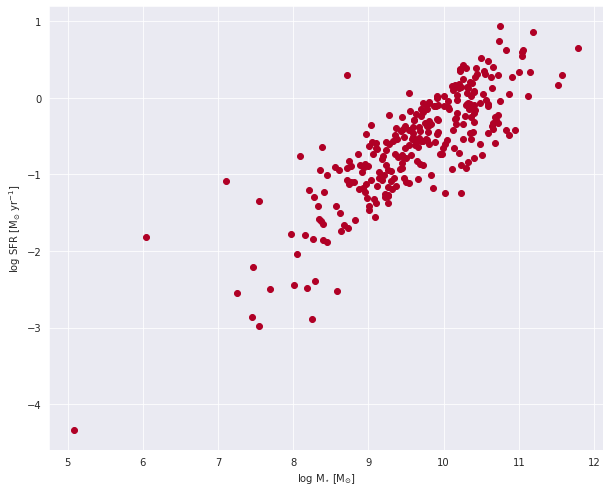

In [19]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logMstar']), dp['logSFR'], marker='o', color=mpl.cm.YlOrRd(0.9),
        linestyle='')
# ax.plot((hrs['logMstar']), hrs['logSFR'], marker='s', color=mpl.cm.YlGnBu(0.7),
#         linestyle='')
ax.set_ylabel('log SFR [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlabel('log M$_{\star}$ [M$_{\odot}$]')

Text(0.5, 0, 'log M$_{\\star}$ [M$_{\\odot}$]')

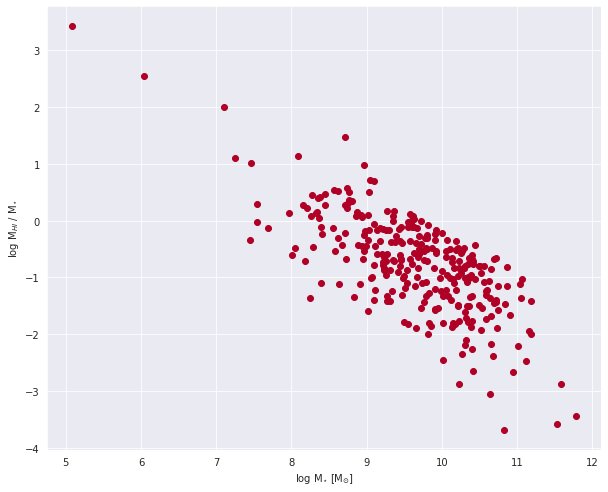

In [20]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logMstar']), dp['logFHI'], marker='o', color=mpl.cm.YlOrRd(0.9),
        linestyle='')
# ax.plot((hrs['logMstar']), hrs['logFHI'], marker='s', color=mpl.cm.YlGnBu(0.7),
#         linestyle='')
ax.set_ylabel('log M$_{HI}$ / M$_{\star}$')
ax.set_xlabel('log M$_{\star}$ [M$_{\odot}$]')

Text(0.5, 0, 'log M$_{\\star}$ [M$_{\\odot}$]')

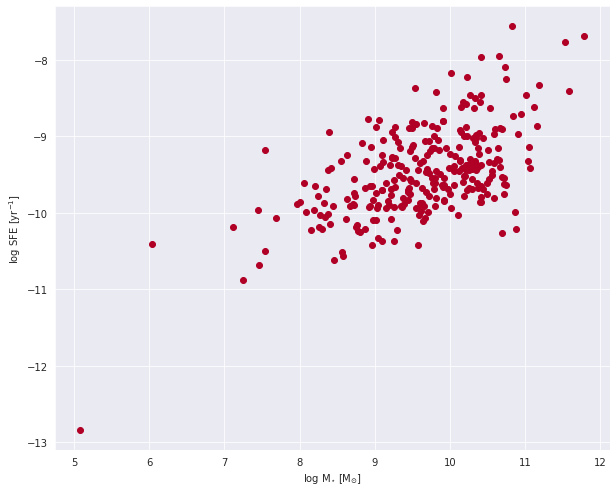

In [21]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logMstar']), dp['logSFE'], marker='o', color=mpl.cm.YlOrRd(0.9),
        linestyle='')
# ax.plot((hrs['logMstar']), hrs['logSFE'], marker='s', color=mpl.cm.YlGnBu(0.7),
#         linestyle='')
ax.set_ylabel('log SFE [yr$^{-1}$]')
ax.set_xlabel('log M$_{\star}$ [M$_{\odot}$]')

Text(0.5, 0, 'log M$_{\\star}$ [M$_{\\odot}$]')

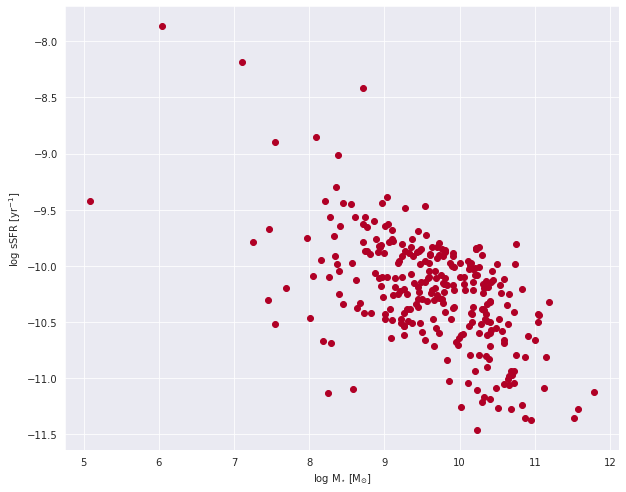

In [22]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logMstar']), dp['logsSFR'], marker='o', color=mpl.cm.YlOrRd(0.9),
        linestyle='')
# ax.plot((hrs['logMstar']), hrs['logsSFR'], marker='s', color=mpl.cm.YlGnBu(0.7),
#         linestyle='')
ax.set_ylabel('log sSFR [yr$^{-1}$]')
ax.set_xlabel('log M$_{\star}$ [M$_{\odot}$]')

As above figures show, the sample consists  of galaxies that are mostly star forming and HI-rich. 

## Dust content of the galaxy sample
### SED modelling with MAGPHYS
While, for the HRS galaxies, the dust mass has been provided by Ciesla et al. (2014), the dust mass for Dustpedia galaxies has not (yet) been published. Hence, we have to estimate the dust content of the Dustpedia galaxies ourselves. To this end we will use the SED modelling tool MAGPHYS (DaCunha et al. 2008). This tool is not run from this notebook, but we can use Python to prepare an appropriate input file for MAGPHYS

In [ ]:
dp['redshift'] = dp['HV'] / c
magphys_dp = dp['Name_1', 'redshift', 'FFUV', 'e_FFUV', 'FNUV', 'e_FNUV', 'Fu', 
                'e_Fu', 'Fg', 'e_Fg', 'Fr', 'e_Fr', 'Fi', 'e_Fi', 'Fz',
                'e_Fz', 'FJ', 'e_FJ', 'FH', 'e_FH', 'FKs', 'e_FKs', 
                'F3_4', 'e_F3_4', 'F3_6', 'e_F3_6', 'F4_5', 'e_F4_5', 
                'F4_6', 'e_F4_6', 'F5_8', 'e_F5_8', 'F8_0', 'e_F8_0', 
                'F12', 'e_F12', 'F22', 'e_F22', 'F24', 'e_F24', 
                'F70', 'e_F70', 'F100P', 'e_F100P', 'F160P', 'e_F160P', 
                'F250', 'e_F250', 'F350', 'e_F350', 'F500', 'e_F500']
magphys_dp = magphys_dp.filled(-99.9)
magphys_dp.write('/home/lutz/Programs/magphys/dustpedia_obs.dat',
                 format='ascii.fixed_width', delimiter='')

The MAGPHYS modelling is now running in a separate commandline. Once it is finished, we read the results into this notebook and add the information from the SED modelling to the Dustpedia table.

In [23]:
def read_in_magphys(filename, values_len):
    try: 
        f = open(filename, 'r')
    except IOError:
        return [-99.9] * values_len
    f = f.readlines()
    if '.s' in filename:
        values1 = f[3].split()
        values2 = f[6].split()
        values = values1 + values2
    elif '.f' in filename:
        values = f[10].split()
    return values

In [45]:
def tabulate_magphys(folder, tab, which_result='.f'):
    items_s = ['fmu(Opt)', 'fmu(IR)', 'tform/yr', 'gamma', 'Z/Zo', 'tauV',
               'mu', 'M*/Msun', 'SFR(1e8)', 'Ld/Lsun', 'xi_C^ISM', 'T_W^BC/K',
               'T_C^ISM/K', 'xi_PAH^BC', 'xi_MIR^BC', 'xi_W^BC', 'Mdust/Mo']
    items_f = ['fmu(SFH)', 'fmu(IR)', 'mu', 'tauv', 'sSFR', 'M*', 'Ldust', 
               'T_W^BC', 'T_C^ISM', 'xi_C^tot', 'xi_PAH^tot', 'xi_MIR^tot', 
               'xi_W^tot', 'tvism', 'Mdust', 'SFR']
    if which_result == '.f':
        items = items_f
    elif which_result == '.s':
        items = items_s  
    out = []
    out_tab = 0
    i = 0
    for galaxy in tab['Name']:
        gal = str(galaxy).split('\'')[1]
        path_to_file = '{}{}*{}*'.format(folder, gal, which_result)
        if (len(glob.glob(path_to_file))) > 0:
            values = read_in_magphys(glob.glob(path_to_file)[0], len(items))
            out.append(values)
        else:
            out.append([-99.9] * len(items))
        i = i + 1
    out_tab = Table(rows=out, names=items_f, dtype=['f8'] * len(items))
    return out_tab

In [46]:
out_tab = tabulate_magphys('/home/klutz/Science/Kat_Dust_HI_Python/magphys_results/', dp)
print(out_tab.colnames)
for col in out_tab.colnames:
    if col in dp.colnames: print(col)
    dp[col] = out_tab[col]

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [47]:
dp

recno,Name,RAJ2000,DEJ2000,MType,MClass,D25,Incl,HV,HVcorr,Distcorr,Dist0,HVH,DistH,Dist0H,Dist,SimbadName,amaj,b_a,PA,Flag,FFUV,e_FFUV,f_FFUV,FNUV,e_FNUV,f_FNUV,Fu,e_Fu,f_Fu,Fg,e_Fg,f_Fg,Fr,e_Fr,f_Fr,Fi,e_Fi,f_Fi,Fz,e_Fz,f_Fz,FJ,e_FJ,f_FJ,FH,e_FH,f_FH,FKs,e_FKs,f_FKs,F3_4,e_F3_4,f_F3_4,F4_6,e_F4_6,f_F4_6,F12,e_F12,f_F12,F22,e_F22,f_F22,F3_6,e_F3_6,f_F3_6,F4_5,e_F4_5,f_F4_5,F5_8,e_F5_8,f_F5_8,F8_0,e_F8_0,f_F8_0,F24,e_F24,f_F24,F70,e_F70,f_F70,F160,e_F160,f_F160,F70P,e_F70P,f_F70P,F100P,e_F100P,f_F100P,F160P,e_F160P,f_F160P,F250,e_F250,f_F250,F350,e_F350,f_F350,F500,e_F500,f_F500,AGCNr,Name_2,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist_2,sigDist,logMH,siglogMH,HIcode,Separation,ra,dec,E_B-V_,E_B-V__2,K flux [Jy],W3 flux [Jy],NUV flux [Jy],K lum [erg/s],W3 lum [erg/s],NUV lum dens [erg/s/Hz],logMstar,logSFR,logFHI,logSFE,logsSFR,fmu(SFH),fmu(IR),mu,tauv,sSFR,M*,Ldust,T_W^BC,T_C^ISM,xi_C^tot,xi_PAH^tot,xi_MIR^tot,xi_W^tot,tvism,Mdust,SFR
,,deg,deg,,,arcsec,deg,km / s,km / s,Mpc,Mpc,km / s,Mpc,Mpc,Mpc,,arcsec,,deg,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,Jy,Jy,,,,,,,,,,,,,,,,,,,,,arcsec,deg,deg,mags,mags,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,object,float64,float64,float64,bytes4,float64,float64,int16,int32,float64,float64,int32,float64,float64,float64,object,float64,float64,float64,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes1,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes3,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,float32,float32,bytes2,int64,str8,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41,NGC0678,27.35355,21.99728,3.0,SBb,3.0903,90.0,2835,2766,37.76625,27.87,2793,38.1349,--,27.87,NGC0678,240.3184,3.11698,-12.666,,0.000544,0.00079,,0.000863,0.000163,,0.00425,0.00589,,0.0376,0.00204,,0.0855,0.00312,,0.133,0.00521,,0.179,0.00704,,0.275,0.0137,,0.31,0.0686,,0.314,0.0539,,0.136,0.0046,,0.0743,0.00362,,0.0823,0.00965,,0.077,0.0141,,0.128,0.00401,N,0.0816,0.00258,N,--,--,,--,--,,--,--,,--,--,,--,--,,--,--,,1.22,0.288,n,3.23,0.337,n,2.16,0.303,,1.01,0.169,,0.294,0.0995,,1280,N.678...,27.35666,22.0,27.35333,21.99639,2836,503,3,519,6.48,0.12,25.9,2.22,38.4,4.1,9.35,0.1,1,3.287077736931423,27.35355,21.99728,0.0741,0.0741,0.3219641692232463,0.08315763904586643,0.0014898096829218154,4.1557675545730117e+43,2.0043811615720994e+42,1.3848618052876571e+27,10.59004861523779,-0.461681192307256,-1.2400486152377912,-9.811681192307256,-11.051729807545048,0.82,0.744,0.314,0.353,2.248e-12,81940000000.0,4616000000.0,48.4,17.3,0.58,0.18,0.197,0.043,0.111,18430000.0,0.1842
44,NGC0855,33.51495,27.87685,-4.8,E,2.9512,90.0,592,693,9.46204,9.28,592,8.08301,9.63829,9.63829,NGC0855,152.8909,1.80451,-19.455,,0.00144,7.76e-05,,0.00296,0.000118,,0.011,0.00284,,0.033,0.0017,,0.0538,0.00126,,0.0695,0.00232,,0.0797,0.00474,,0.0983,0.0169,,0.149,0.0835,,0.111,0.0336,,0.0442,0.00247,,0.0236,0.003,,0.0393,0.00594,,0.108,0.0146,,0.0445,0.00185,n,0.0297,0.00117,n,0.0348,0.00478,n,0.047,0.00176,n,0.0824,0.00602,,--,--,,--,--,,1.86,0.373,,2.73,0.679,,2.1,0.469,,1.1,0.23,,0.474,0.12,,0.147,0.0752,,1718,N.

### Characterisation of the SED modelling results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


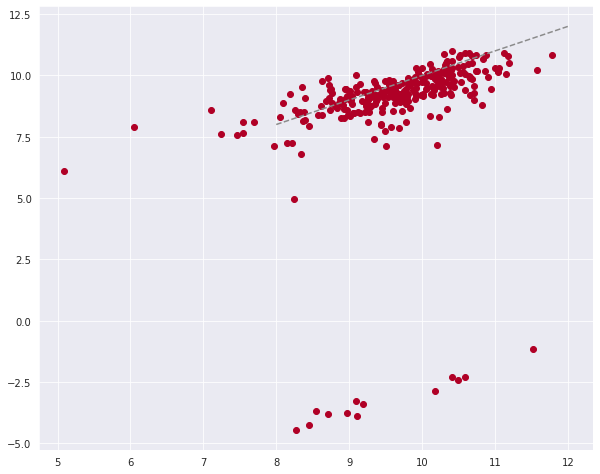

In [48]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot(dp['logMstar'], np.log10(dp['M*']), marker='o', color=mpl.cm.YlOrRd(0.9),
        linestyle='')
ax.plot(np.arange(8, 13), np.arange(8.0, 13.), linestyle='--', 
        color='#8b8b8b')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


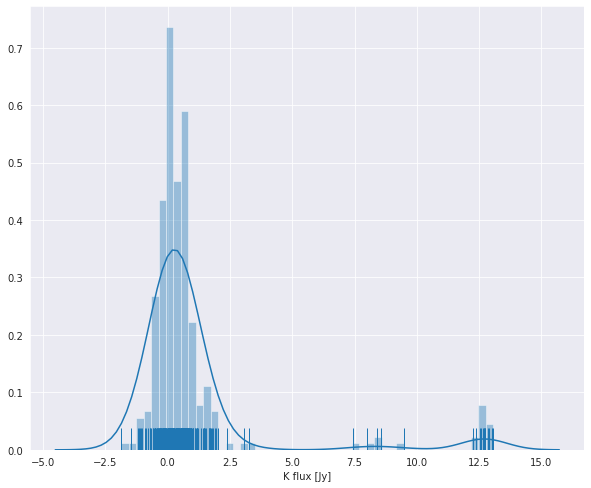

In [49]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot((dp['logMstar']) - np.log10(dp['M*']), ax=ax, rug=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


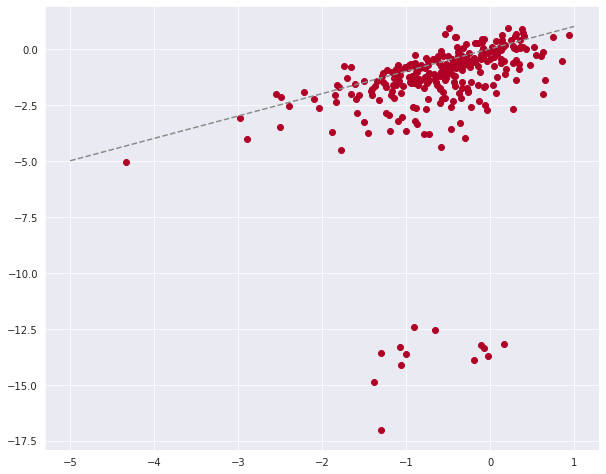

In [50]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logSFR']), np.log10(dp['SFR']), marker='o', color=mpl.cm.YlOrRd(0.9),
        linestyle='')
ax.plot(np.arange(-5, 2), np.arange(-5, 2), linestyle='--', 
        color='#8b8b8b')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


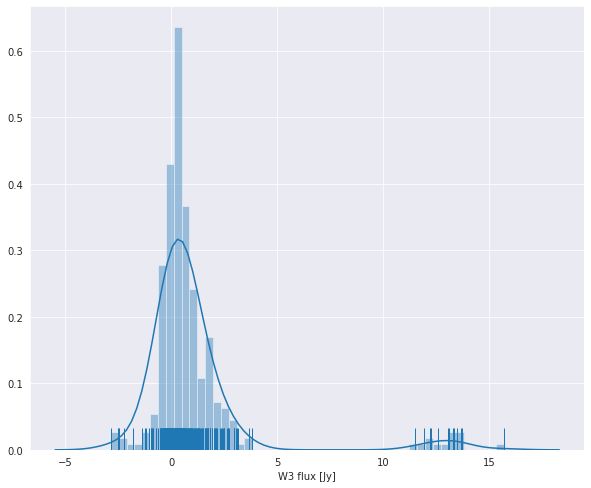

In [51]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot((dp['logSFR']) - np.log10(dp['SFR']), ax=ax, rug=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


Text(0.5, 0, 'log M$_{\\star}$ [M$_{\\odot}$]')

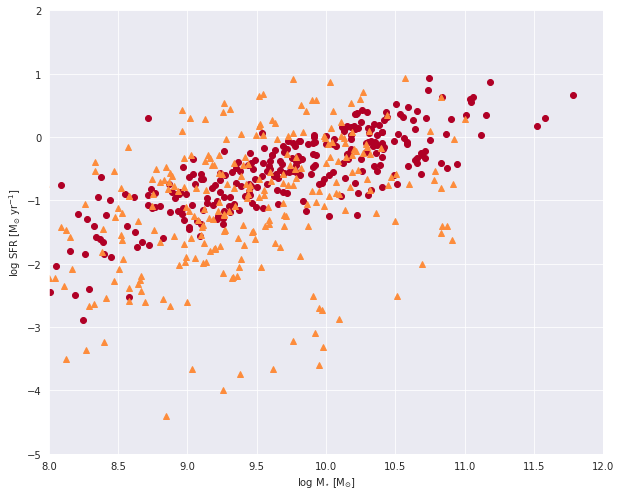

In [54]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logMstar']), dp['logSFR'], marker='o', 
        color=mpl.cm.YlOrRd(0.9), linestyle='')
# ax.plot((hrs['logMstar']), hrs['logSFR'], marker='s', color=mpl.cm.YlGnBu(0.7),
#         linestyle='')
ax.plot(np.log10(dp['M*']), np.log10(dp['SFR']), 
        marker='^', color=mpl.cm.YlOrRd(0.5),
        linestyle='')
ax.set_xlim([8.0, 12.0])
ax.set_ylim([-5.0, 2.0])
ax.set_ylabel('log SFR [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlabel('log M$_{\star}$ [M$_{\odot}$]')

The results for stellar mass and star formation rate from the SED modelling do not agree in all cases with the estimates from photometry. There are in particular a few galaxies that have very low star formation rates and/or negative stellar masses. They as well as galaxies with stellar masses below $10^{8.5}$ from either of the stellar mass determination methods will be removed from the sample. 

In [55]:
ind_dp = dp['logMstar'] > 8.5 #& \
#          dp['M*'] > 10.**(8.5) & \
#          dp['SFR'] > 10**(5.0)
dp_clean = dp[ind_dp]
ind_dp = dp_clean['M*'] > 10.**(8.5)
dp_clean = dp_clean[ind_dp]
ind_dp = dp_clean['SFR'] > 10.**(-5.0)
dp_clean = dp_clean[ind_dp]
print(len(dp_clean))

227


As we have seen above in the Aladin Lite widget, there is some overlap between the Dustpedia and the HRS sample. In order to qualify the amount of overlap and to be able to compare the dust masses from Dustpedia/MAGPHYS with the dust masses from HRS, we again use TOPCAT to cross-match the two tables. 

In [56]:
dp_clean.write('dustpedia_dustmodel.vot', format='votable', overwrite=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0.5, 0, 'log M$_{\\star}$ [M$_{\\odot}$]')

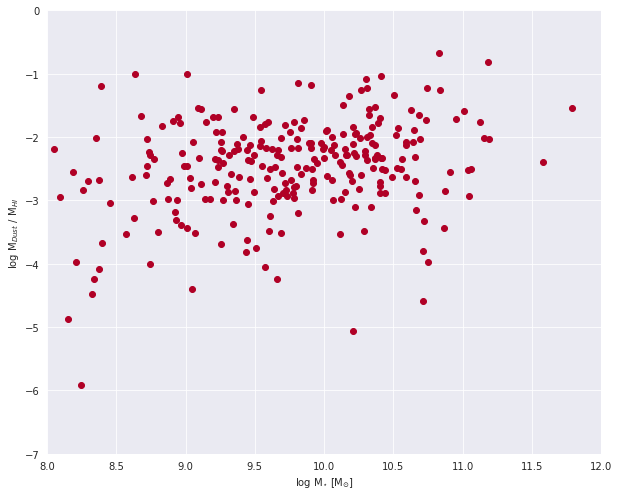

In [61]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot((dp['logMstar']), np.log10(dp['Mdust'] / 10**dp['logMH']), marker='o', 
        color=mpl.cm.YlOrRd(0.9), linestyle='')
ax.set_xlim([8.0, 12.0])
ax.set_ylim([-7.0, 0.0])
ax.set_ylabel('log M$_{Dust}$ / M$_{HI}$')
ax.set_xlabel('log M$_{\star}$ [M$_{\odot}$]')

In [57]:
dp_x_hrs = Table.read('hrs_Xmatch_dustpedia.vot', format='votable')

(6.0, 8.5)

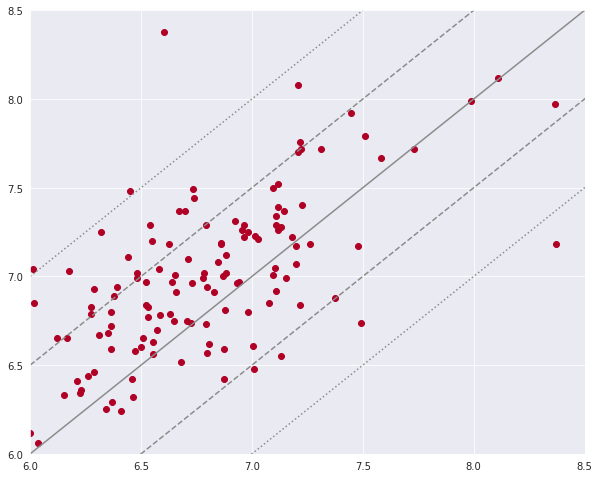

In [58]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot(np.log10(dp_x_hrs['Mdust']), dp_x_hrs['log_Mdust_'], marker='o', 
        color=mpl.cm.YlOrRd(0.9), linestyle='')
ax.plot(np.arange(6, 11), np.arange(6, 11), linestyle='-', 
        color='#8b8b8b')
ax.plot(np.arange(6, 11), np.arange(7, 12), linestyle=':', 
        color='#8b8b8b')
ax.plot(np.arange(6, 11), np.arange(5, 10), linestyle=':', 
        color='#8b8b8b')
ax.plot(np.arange(6, 11), np.arange(6.5, 11.5), linestyle='--', 
        color='#8b8b8b')
ax.plot(np.arange(6, 11), np.arange(5.5, 10.5), linestyle='--', 
        color='#8b8b8b')
ax.set_xlim([6.0, 8.5])
ax.set_ylim([6.0, 8.5])

In [ ]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10., 8.))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(np.log10(dp_x_hrs['Mdust']) - dp_x_hrs['log_Mdust_'], 
             ax=ax, rug=True)